# **MACHINE LEARNING ASSIGNMENT # 02**

# **Implementation of concepts of Linear Regression and Gradient Descent**

## ***Step 01: Importing the Libraries***


In [ ]:
import pandas as pd
import numpy as np
import copy
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.axes as ax
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

In [ ]:
# Set the style for seaborn
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# ***Step 02: Loading the dataset***

In [ ]:
def load_data(file_path):
    return pd.read_csv(file_path)

data = load_data("data.csv")
data.shape

(4600, 18)

In [ ]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date']) # Convert the 'date' column to datetime objects for easier manipulation
data['year_sold'] = data['date'].dt.year # Extract the year the house was sold
data['month_sold'] = data['date'].dt.month # Extract the month the house was sold


# Calculate house age at time of sale
data['house_age'] = data['year_sold'] - data['yr_built']

# Calculate years since renovation, handling the case where yr_renovated is 0
data['years_since_renovation'] = data.apply(lambda row: row['year_sold'] - row['yr_renovated'] if row['yr_renovated'] > 0 else row['house_age'], axis=1)

# Print the 'years_since_renovation' column
print(data['years_since_renovation'])

0        9
1       93
2       48
3       51
4       22
        ..
4595    35
4596     5
4597     5
4598    40
4599    24
Name: years_since_renovation, Length: 4600, dtype: int64


In [ ]:
# Identify numeric and categorical columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns
print("Columns:", data.columns)
print("Numeric Columns:", numeric_cols)
print("Categorical Column:", categorical_cols)

Columns: Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'street', 'city',
       'statezip', 'country', 'year_sold', 'month_sold', 'house_age',
       'years_since_renovation'],
      dtype='object')
Numeric Columns: Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'house_age', 'years_since_renovation'],
      dtype='object')
Categorical Column: Index(['street', 'city', 'statezip', 'country'], dtype='object')


In [ ]:
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,street,city,statezip,country,year_sold,month_sold,house_age,years_since_renovation
0,2014-05-02,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,...,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA,2014,5,59,9
1,2014-05-02,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,...,1921,0,709 W Blaine St,Seattle,WA 98119,USA,2014,5,93,93
2,2014-05-02,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,...,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA,2014,5,48,48
3,2014-05-02,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,...,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA,2014,5,51,51
4,2014-05-02,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,...,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA,2014,5,38,22


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    4600 non-null   datetime64[ns]
 1   price                   4600 non-null   float64       
 2   bedrooms                4600 non-null   float64       
 3   bathrooms               4600 non-null   float64       
 4   sqft_living             4600 non-null   int64         
 5   sqft_lot                4600 non-null   int64         
 6   floors                  4600 non-null   float64       
 7   waterfront              4600 non-null   int64         
 8   view                    4600 non-null   int64         
 9   condition               4600 non-null   int64         
 10  sqft_above              4600 non-null   int64         
 11  sqft_basement           4600 non-null   int64         
 12  yr_built                4600 non-null   int64   

In [ ]:
data.describe()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,year_sold,month_sold,house_age,years_since_renovation
count,4600,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.0,4600.000000,4600.000000,4600.000000
mean,2014-06-07 03:14:42.782608640,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261,2014.0,5.757609,43.213696,28.957391
min,2014-05-02 00:00:00,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000,2014.0,5.000000,0.000000,0.000000
25%,2014-05-21 00:00:00,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000,2014.0,5.000000,17.000000,9.000000
50%,2014-06-09 00:00:00,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000,2014.0,6.000000,38.000000,20.000000
75%,2014-06-24 00:00:00,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000,2014.0,6.000000,63.000000,41.000000
max,2014-07-10 00:00:00,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000,2014.0,7.000000,114.000000,114.000000
std,NaN,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536,0.0,0.683851,29.731848,26.863922


# ***Step 03: Data Cleaning***



1.   Remove Duplicates



In [ ]:
print("Duplicate rows", data.duplicated().sum())
if data.duplicated().sum() > 0:
    data = data.drop_duplicates()

Duplicate rows 0



2.  Handle Missing Values



In [ ]:
def missing_value_analysis(data):
    print("=== Missing Value Analysis ===")

    # Check for duplicates
    duplicates = data.duplicated().sum()
    print(f"\nNumber of duplicate rows: {duplicates}")
    data = data.drop_duplicates()

    # Missing values analysis
    missing_values = data.isnull().sum()
    missing_percentages = (missing_values / len(data)) * 100

    missing_df = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percentages
    })
    print("\nMissing Values Summary:")
    print(missing_df[missing_df['Missing Values'] > 0])

    return data, missing_df

data, missing_df = missing_value_analysis(data)
print(data.head())

=== Missing Value Analysis ===

Number of duplicate rows: 0

Missing Values Summary:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
        date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0 2014-05-02   313000.0       3.0       1.50         1340      7912     1.5   
1 2014-05-02  2384000.0       5.0       2.50         3650      9050     2.0   
2 2014-05-02   342000.0       3.0       2.00         1930     11947     1.0   
3 2014-05-02   420000.0       3.0       2.25         2000      8030     1.0   
4 2014-05-02   550000.0       4.0       2.50         1940     10500     1.0   

   waterfront  view  condition  ...  yr_built  yr_renovated  \
0           0     0          3  ...      1955          2005   
1           0     4          5  ...      1921             0   
2           0     0          4  ...      1966             0   
3           0     0          4  ...      1963             0   
4           0     0          4  ...      1976          1992  


3.  Categorial Encoding



In [ ]:
def categorical_encoding(data):
        # Label Encoding
        le = LabelEncoder()

        for col in categorical_cols:
            if col in data.columns:
                data[f'{col}_encoded'] = le.fit_transform(data[col].astype(str))

        return data

data = categorical_encoding(data)
print(data.head())

        date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0 2014-05-02   313000.0       3.0       1.50         1340      7912     1.5   
1 2014-05-02  2384000.0       5.0       2.50         3650      9050     2.0   
2 2014-05-02   342000.0       3.0       2.00         1930     11947     1.0   
3 2014-05-02   420000.0       3.0       2.25         2000      8030     1.0   
4 2014-05-02   550000.0       4.0       2.50         1940     10500     1.0   

   waterfront  view  condition  ...  statezip  country  year_sold  month_sold  \
0           0     0          3  ...  WA 98133      USA       2014           5   
1           0     4          5  ...  WA 98119      USA       2014           5   
2           0     0          4  ...  WA 98042      USA       2014           5   
3           0     0          4  ...  WA 98008      USA       2014           5   
4           0     0          4  ...  WA 98052      USA       2014           5   

  house_age years_since_renovation str


4.   Feature Scaling



In [ ]:
def feature_scaling(data):
        scaler = StandardScaler()

        # Create scaled versions of numeric columns
        for col in numeric_cols:
            if col in data.columns:
                data[f'{col}_scaled'] = scaler.fit_transform(data[[col]])

        return data

data = feature_scaling(data)
# Display the data to visualize changes
print(data.head())

        date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0 2014-05-02   313000.0       3.0       1.50         1340      7912     1.5   
1 2014-05-02  2384000.0       5.0       2.50         3650      9050     2.0   
2 2014-05-02   342000.0       3.0       2.00         1930     11947     1.0   
3 2014-05-02   420000.0       3.0       2.25         2000      8030     1.0   
4 2014-05-02   550000.0       4.0       2.50         1940     10500     1.0   

   waterfront  view  condition  ...  floors_scaled  waterfront_scaled  \
0           0     0          3  ...      -0.022416          -0.085004   
1           0     4          5  ...       0.906555          -0.085004   
2           0     0          4  ...      -0.951388          -0.085004   
3           0     0          4  ...      -0.951388          -0.085004   
4           0     0          4  ...      -0.951388          -0.085004   

   view_scaled  condition_scaled sqft_above_scaled sqft_basement_scaled  \
0    -0.309

# ***Step 03: Data Visualization***

1. Distribution of House Prices

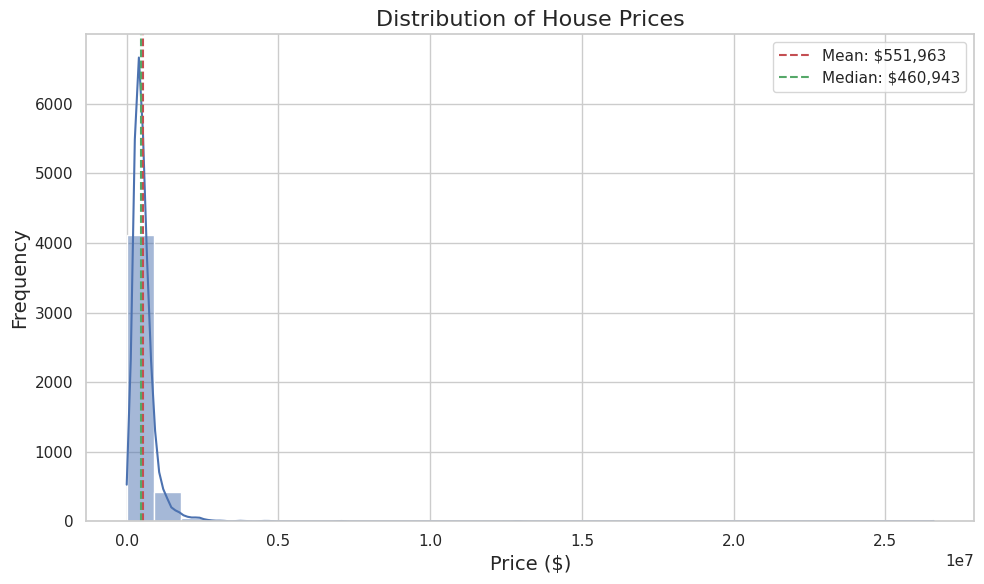

In [ ]:
# 1. Distribution of House Prices
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], kde=True, bins=30) # Create a figure with a specific size (10 inches wide, 6 inches tall)
plt.title('Distribution of House Prices', fontsize=16)
plt.xlabel('Price ($)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
# Add a vertical line for the mean price
plt.axvline(data['price'].mean(), color='r', linestyle='--', label=f'Mean: ${data["price"].mean():,.0f}')
 # Add a vertical line for the median price
plt.axvline(data['price'].median(), color='g', linestyle='--', label=f'Median: ${data["price"].median():,.0f}')
plt.legend()
# Adjust the layout to prevent overlapping elements
plt.tight_layout()
plt.savefig('price_distribution.png')
plt.show()

**Explanation:** This plot shows the distribution of house prices with a strong positive skew, meaning most houses are priced at the lower end (around $450,000-$550,000) while fewer properties extend into the much higher price ranges (up to $25 million).

The significant gap between mean and median values confirms this right-skewed distribution, indicating that some extremely expensive outlier properties are pulling the average higher than what most houses actually cost.

2. Correlation Heatmap of Numeric Features

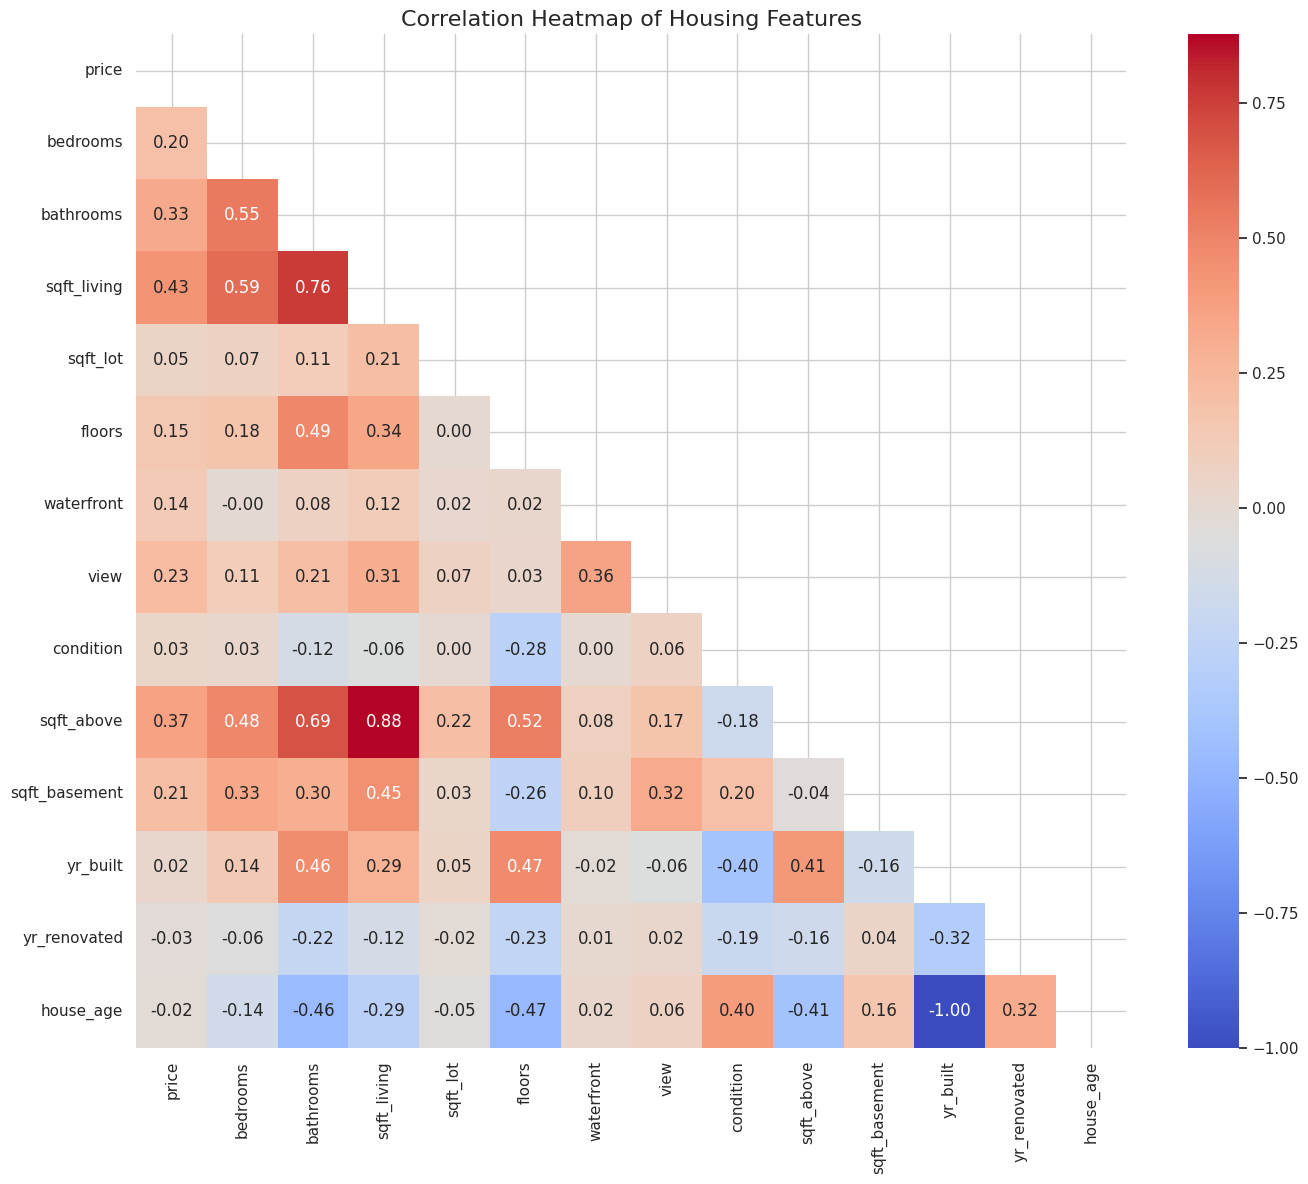

In [ ]:
# 2. Correlation Heatmap of Numeric Features
numeric_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'waterfront', 'view', 'condition', 'sqft_above',
                'sqft_basement', 'yr_built', 'yr_renovated', 'house_age']

plt.figure(figsize=(14, 12))
correlation_matrix = data[numeric_cols].corr()
mask = np.triu(correlation_matrix) # used to hide duplicate correlations (since corr(A,B) = corr(B,A))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Heatmap of Housing Features', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

**Explanation:**
This correlation heatmap shows relationships between various housing features. Darker red indicates a strong positive correlation, while blue represents a negative correlation. Key insights include:




*   Sqft living and price have the highest correlation (~0.76), meaning larger homes tend to have higher prices.
*   Bathrooms and bedrooms also show moderate correlations with price.
* House age has a negative correlation with price, suggesting newer homes are generally more expensive



3. Price vs. Key Features Scatter Plots

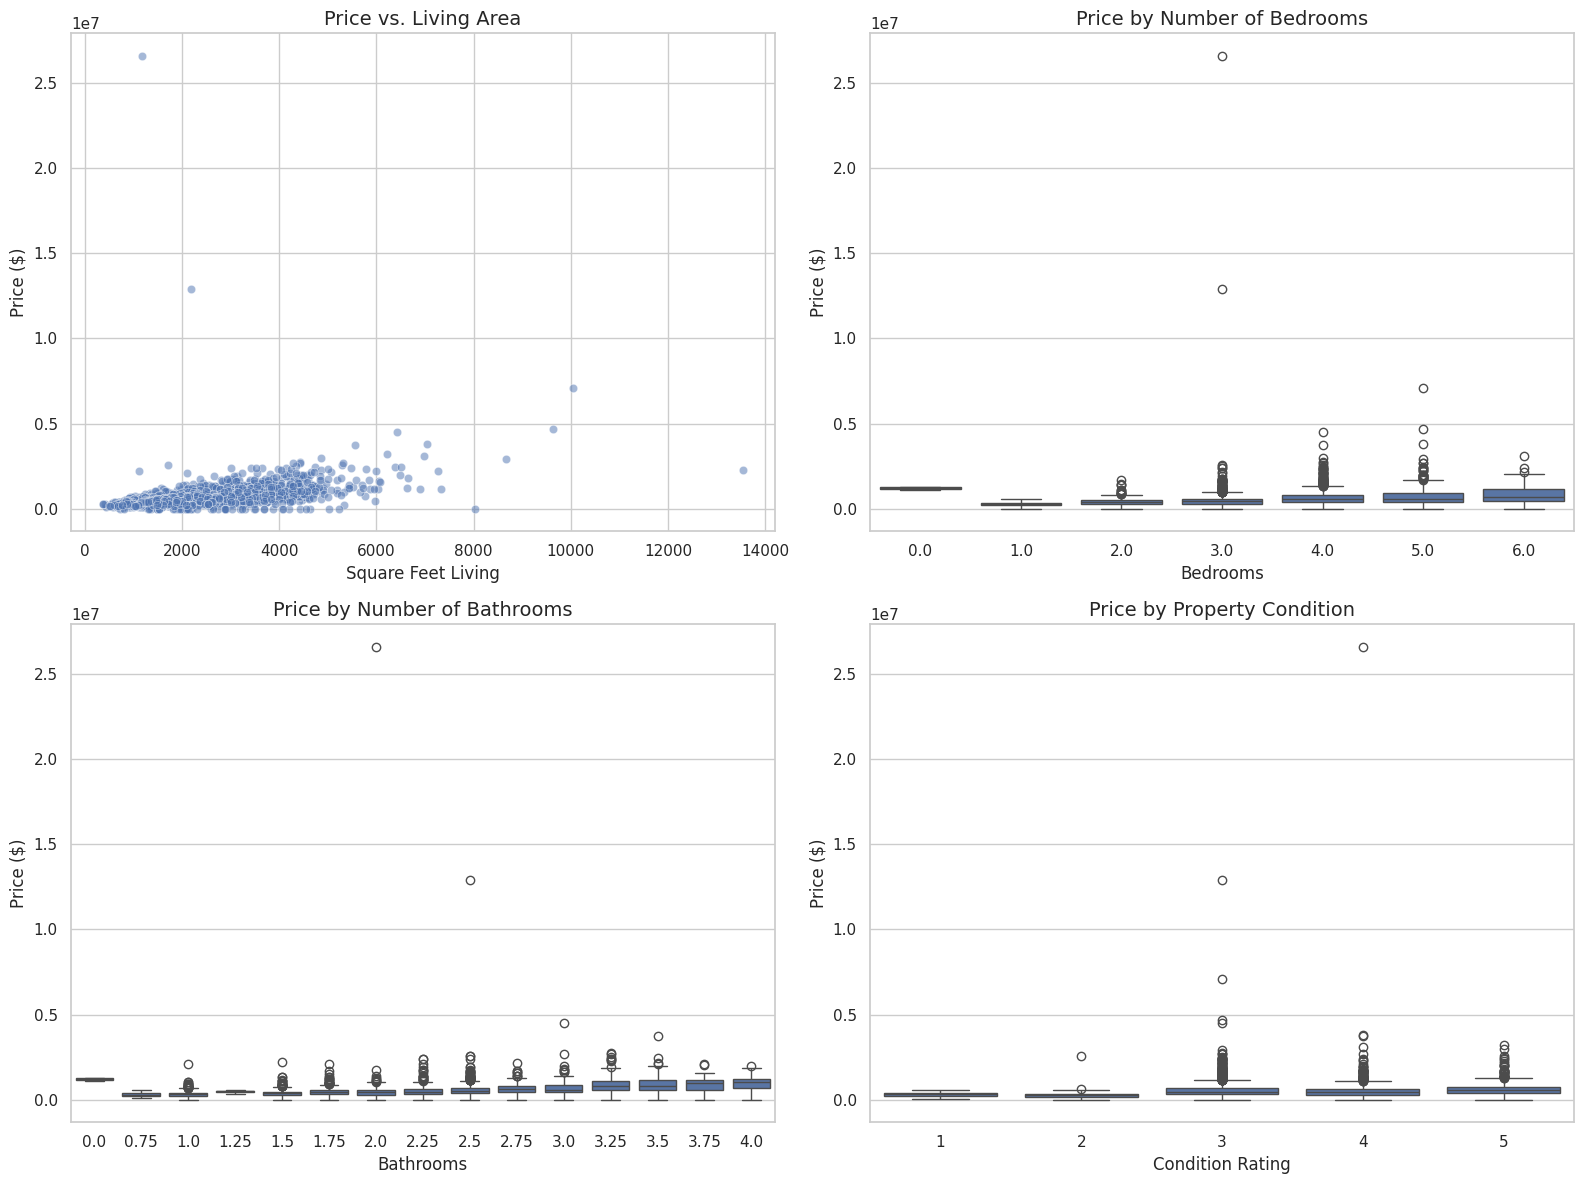

In [ ]:
# 3. Price vs. Key Features Scatter Plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Price vs Living Area
sns.scatterplot(x='sqft_living', y='price', data=data, alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title('Price vs. Living Area', fontsize=14)
axes[0, 0].set_xlabel('Square Feet Living', fontsize=12)
axes[0, 0].set_ylabel('Price ($)', fontsize=12)

# Price vs Bedrooms
sns.boxplot(x='bedrooms', y='price', data=data[data['bedrooms'] <= 6], ax=axes[0, 1])
axes[0, 1].set_title('Price by Number of Bedrooms', fontsize=14)
axes[0, 1].set_xlabel('Bedrooms', fontsize=12)
axes[0, 1].set_ylabel('Price ($)', fontsize=12)

# Price vs Bathrooms
sns.boxplot(x='bathrooms', y='price', data=data[data['bathrooms'] <= 4], ax=axes[1, 0])
axes[1, 0].set_title('Price by Number of Bathrooms', fontsize=14)
axes[1, 0].set_xlabel('Bathrooms', fontsize=12)
axes[1, 0].set_ylabel('Price ($)', fontsize=12)

# Price vs Condition
sns.boxplot(x='condition', y='price', data=data, ax=axes[1, 1])
axes[1, 1].set_title('Price by Property Condition', fontsize=14)
axes[1, 1].set_xlabel('Condition Rating', fontsize=12)
axes[1, 1].set_ylabel('Price ($)', fontsize=12)

plt.tight_layout()
plt.savefig('price_vs_features.png')
plt.show()

**Explanation:**


1. Price vs. Living Area (Scatter Plot): This plot shows the correlation between house prices and living area (square feet).
The trend suggests that larger homes generally have higher prices, but there are some extreme outliers.
Some very large homes (above 10,000 sq. ft.) have significantly higher prices.
2.  Price by Number of Bedrooms (Box Plot): This box plot displays how house prices vary by the number of bedrooms.
The median price appears to increase slightly with more bedrooms, but there is a lot of variability.
Some high-priced outliers exist across all bedroom categories.
3.  Price by Number of Bathrooms (Box Plot)
This plot shows the distribution of house prices based on the number of bathrooms.
Houses with more bathrooms tend to have higher prices, but again, there are many outliers.
The price range is wide across all categories.
4.  Price by Property Condition (Box Plot): This plot examines the effect of property condition ratings on price.
Higher condition ratings (better quality homes) seem to correspond with higher median prices.
However, outliers exist in all categories, meaning other factors influence price beyond just condition.

4. Price by Waterfront and View

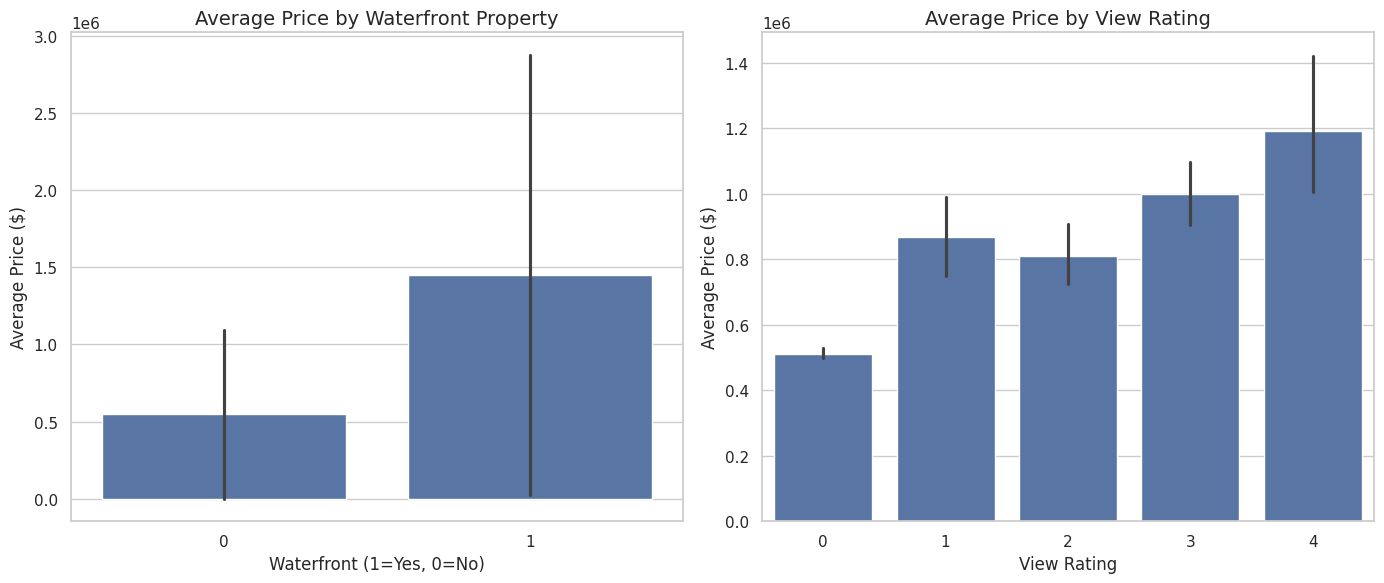

In [ ]:
# 4. Price by Waterfront and View
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='waterfront', y='price', data=data, errorbar='sd')  # Updated line
plt.title('Average Price by Waterfront Property', fontsize=14)
plt.xlabel('Waterfront (1=Yes, 0=No)', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)

plt.subplot(1, 2, 2)
sns.barplot(x='view', y='price', data=data)
plt.title('Average Price by View Rating', fontsize=14)
plt.xlabel('View Rating', fontsize=12)
plt.ylabel('Average Price ($)', fontsize=12)

plt.tight_layout()
plt.savefig('price_by_location_features.png')
plt.show()

Explanation: These plots show how house prices change based on waterfront access and view rating:

1. Waterfront Property (Left Plot):Homes with waterfront access are much more expensive than those without.
Prices for waterfront homes vary a lot, as shown by the large error bar.
2. View Rating (Right Plot):Houses with better views have higher prices. Prices increase as the view rating goes up from 0 to 4.

5. Geographical Analysis by City

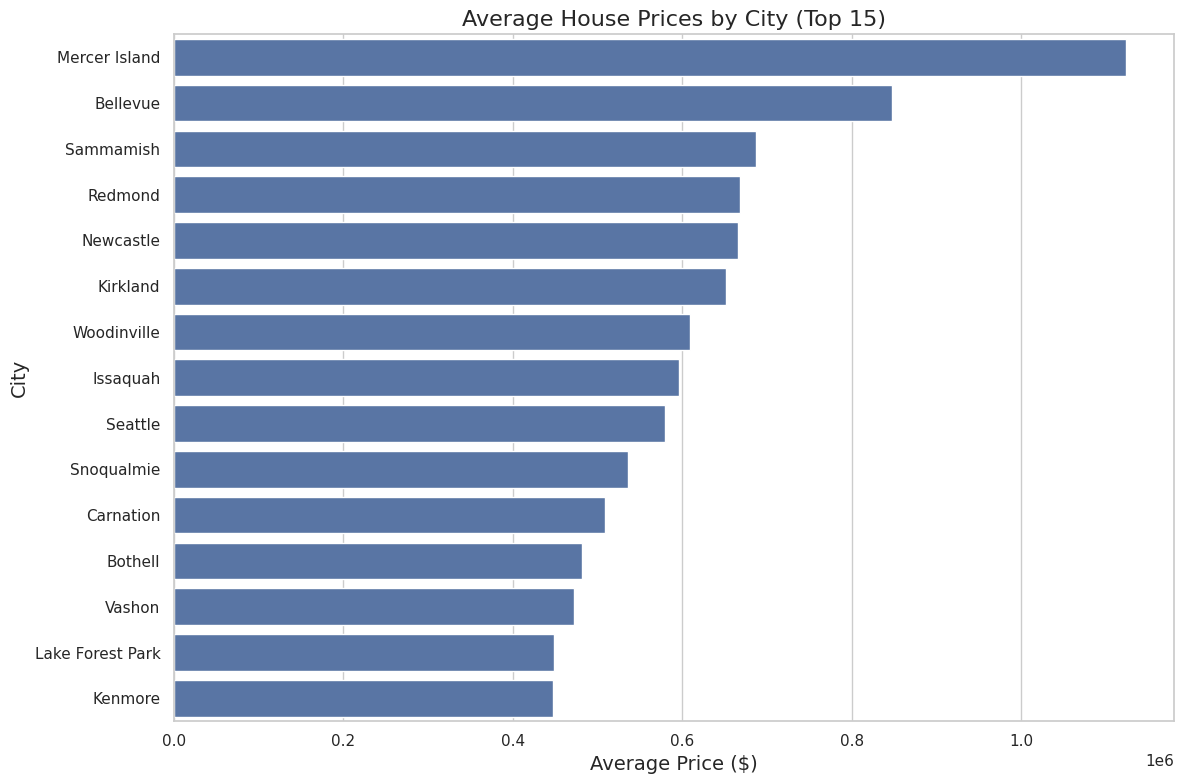

In [ ]:
# 5. Geographical Analysis by City
plt.figure(figsize=(12, 8))
# create a new DataFrame called city_prices containing the city, average price, and the number of houses in that city.
city_prices = data.groupby('city')['price'].agg(['mean', 'count']).reset_index()
city_prices = city_prices.sort_values('mean', ascending=False)
city_prices = city_prices[city_prices['count'] > 20]  # Only cities with sufficient data

sns.barplot(x='mean', y='city', data=city_prices.head(15))
plt.title('Average House Prices by City (Top 15)', fontsize=16)
plt.xlabel('Average Price ($)', fontsize=14)
plt.ylabel('City', fontsize=14)
plt.tight_layout()
plt.savefig('price_by_city.png')
plt.show()

**Explanation:** This bar chart shows the top 15 cities with the highest average house prices.

*   Mercer Island has the highest average home price, significantly higher than the rest.
*   Bellevue follows in second place, with prices also well above most other cities.
* Other cities like Sammamish, Redmond, and Newcastle also have high home values.
* Cities at the lower end of this list, such as Kenmore and Lake Forest Park, still have relatively high prices but are more affordable compared to the top-ranked cities.

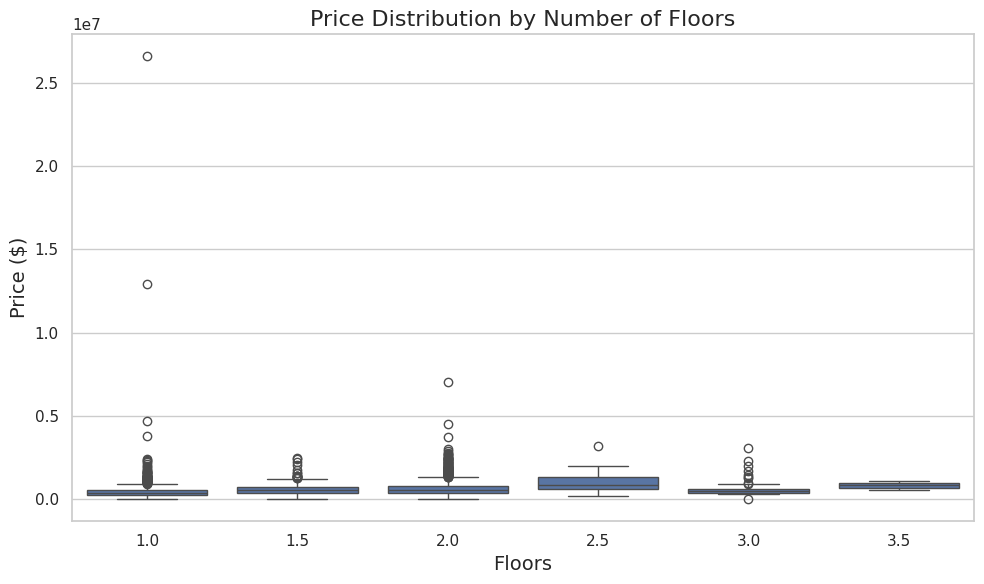

In [ ]:
# 6. Price Distribution by Floor Count
plt.figure(figsize=(10, 6))
sns.boxplot(x='floors', y='price', data=data)
plt.title('Price Distribution by Number of Floors', fontsize=16)
plt.xlabel('Floors', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.tight_layout()
plt.savefig('price_by_floors.png')
plt.show()

**Explanation:** This box plot shows the price distribution of houses based on the number of floors.
Houses with 1 to 3.5 floors are included in the analysis.
The median price remains relatively stable across different floor counts.
There are outliers, with some homes priced significantly higher, especially for 1-floor and 2-floor homes.
Houses with 2.5 or more floors tend to have slightly higher prices but do not show a strong increasing trend.
Hence,the number of floors does not strongly impact house prices, but there are high-value outliers, especially in homes with 1 or 2 floors.

7. Living Area vs. Lot Size with Price Color Coding

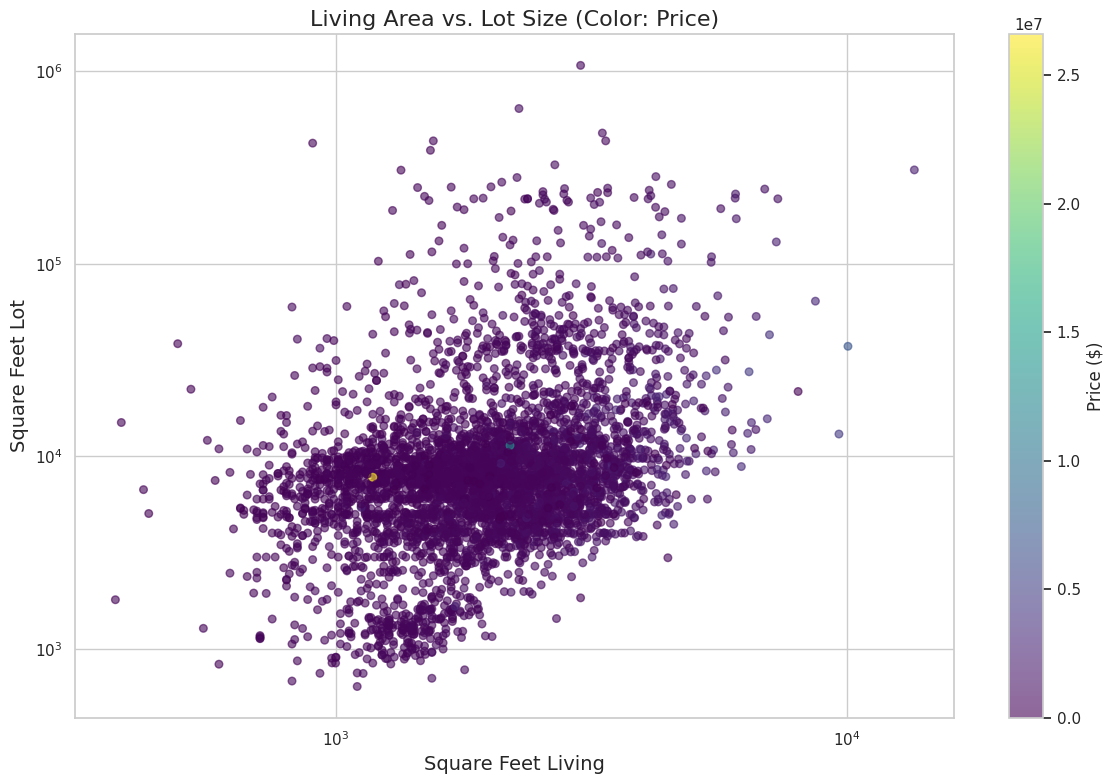

In [ ]:
# 7. Living Area vs. Lot Size with Price Color Coding
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data['sqft_living'], data['sqft_lot'],
                      c=data['price'], cmap='viridis',
                      s=30, alpha=0.6)
plt.colorbar(scatter, label='Price ($)')
plt.title('Living Area vs. Lot Size (Color: Price)', fontsize=16)
plt.xlabel('Square Feet Living', fontsize=14)
plt.ylabel('Square Feet Lot', fontsize=14)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.savefig('living_area_vs_lot_size.png')
plt.show()

**Explanation:** This scatter plot visualizes the relationship between living area (square feet) and lot size (square feet) for houses, with color representing the price.
* Both axes are on a logarithmic scale, meaning values increase exponentially.
* There is a positive correlation, as larger living areas tend to have larger lot sizes.
* Most houses are clustered in the lower range (smaller homes and lots).
* A few houses have very large lots and living areas, appearing as outliers.
* The color bar shows that higher-priced homes tend to have larger living areas and lots, though some exceptions exist.

# **Linear Regression using Gradient Descent**

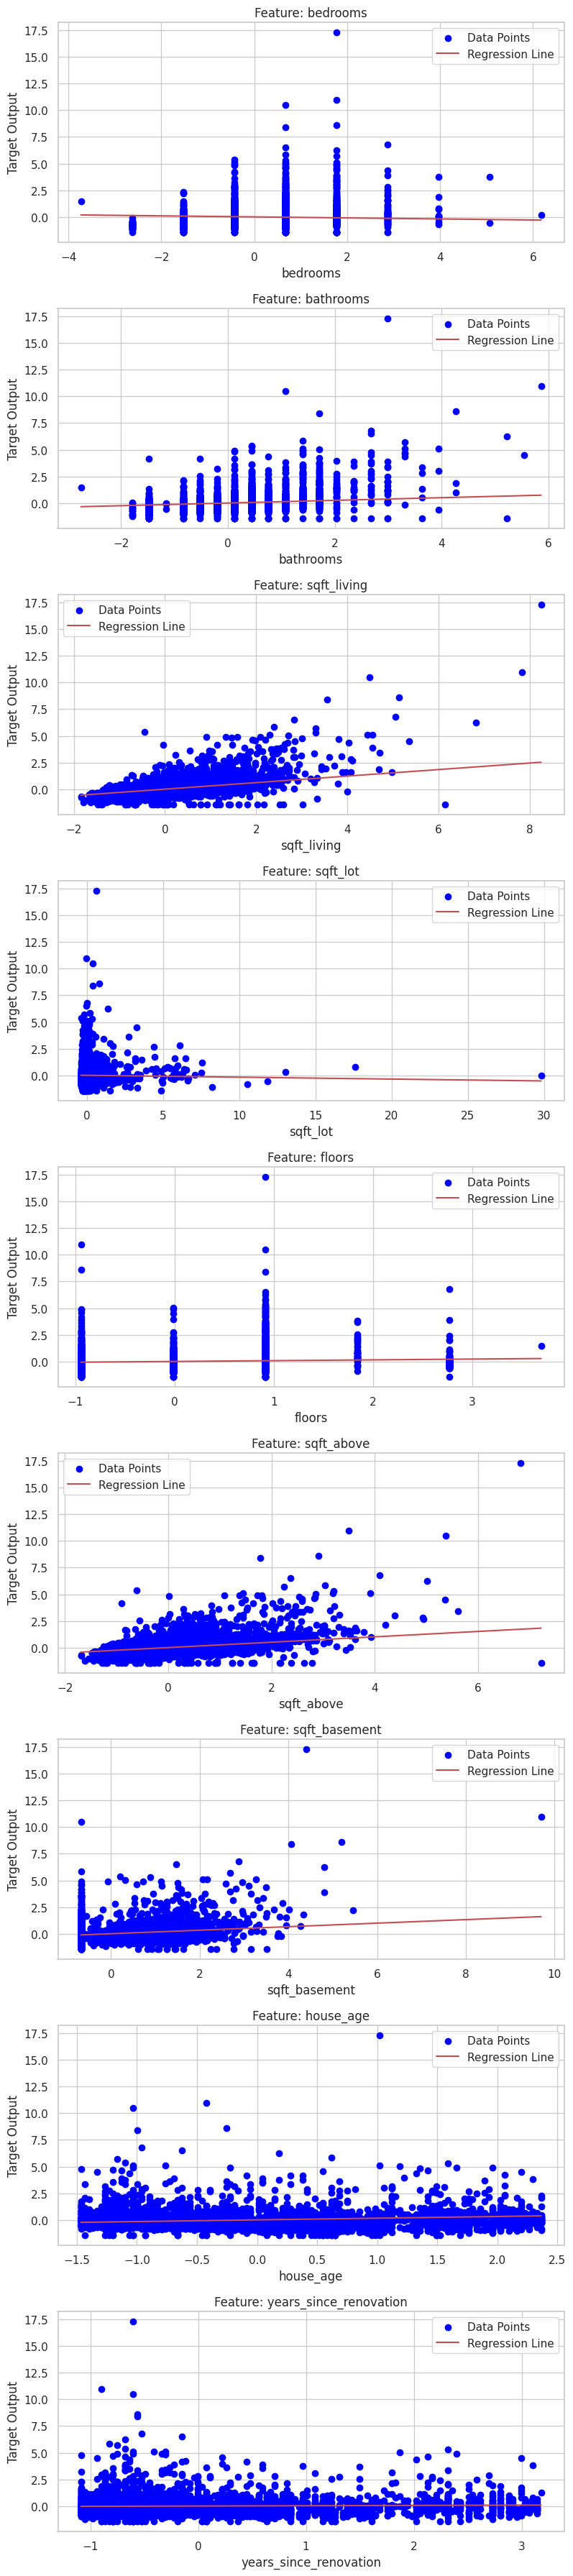

In [ ]:

class LinearRegression:
    def __init__(self):
        self.parameters = {}

    def forward_propagation(self, train_input):
        m = self.parameters['m']
        c = self.parameters['c']
        return np.dot(train_input, m) + c if train_input.ndim > 1 else np.multiply(m, train_input) + c

    def cost_function(self, predictions, train_output):
        return np.mean((train_output - predictions) ** 2)

    def backward_propagation(self, train_input, train_output, predictions):
        error = predictions - train_output
        m = len(train_input)
        dm = (2 / m) * np.dot(train_input.T, error) if train_input.ndim > 1 else (2 / m) * np.sum(train_input * error)
        dc = (2 / m) * np.sum(error)
        return {'dm': dm, 'dc': dc}

    def update_parameters(self, derivatives, learning_rate):
        self.parameters['m'] -= learning_rate * derivatives['dm']
        self.parameters['c'] -= learning_rate * derivatives['dc']

    def train(self, train_input, train_output, learning_rate=0.01, iters=100):
        multivariate = train_input.ndim > 1 and train_input.shape[1] > 1
        train_output = np.array(train_output).flatten()
        self.parameters['m'] = np.zeros(train_input.shape[1]) if multivariate else 0
        self.parameters['c'] = 0
        self.loss = []

        for i in range(iters):
            predictions = self.forward_propagation(train_input)
            cost = self.cost_function(predictions, train_output)
            self.loss.append(cost)
            derivatives = self.backward_propagation(train_input, train_output, predictions)
            self.update_parameters(derivatives, learning_rate)

        return self.parameters, self.loss

    def plot_all_features(self, train_input, train_output, feature_names):
        num_features = train_input.shape[1]
        fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(8, 4 * num_features))
        feature_means = np.mean(train_input, axis=0)  # Compute mean for each feature

        for i, ax in enumerate(axes):
            feature_vals = train_input[:, i]
            x_vals = np.linspace(min(feature_vals), max(feature_vals), 100)
            dummy_input = np.tile(feature_means, (len(x_vals), 1))
            dummy_input[:, i] = x_vals  # Only change the current feature
            y_vals = self.forward_propagation(dummy_input)

            ax.scatter(feature_vals, train_output, color='blue', label='Data Points')
            ax.plot(x_vals, y_vals, 'r-', label='Regression Line')
            ax.set_xlabel(feature_names[i])
            ax.set_ylabel("Target Output")
            ax.set_title(f"Feature: {feature_names[i]}")
            ax.legend()

        plt.tight_layout()
        plt.show()

# Load dataset
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
            'sqft_above', 'sqft_basement', 'house_age', 'years_since_renovation']
X = data[features]
y = data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

# Train model
model = LinearRegression()
params, loss = model.train(X_train, y_train, learning_rate=0.01, iters=100)

# Plot all features
model.plot_all_features(X_train, y_train, features)


**Explanation:**
The train_test_split function is used to divide a dataset into training and testing sets. In this case, 80% of the data is used for training, while 20% is reserved for testing, as specified by test_size=0.2.The number you set for random_state acts as a seed for the random number generator. It controls how the dataset is shuffled but does not determine how many rows are shuffled.
The blue dots are actual data points, while the red line is the predicted regression line. The model has completed 100 iterations, with a final cost of 0.130745, indicating how well the model fits the data. The positive slope suggests a direct relationship between the feature and the target output. However, the scattered points indicate some variance, suggesting the model may not perfectly capture all patterns.

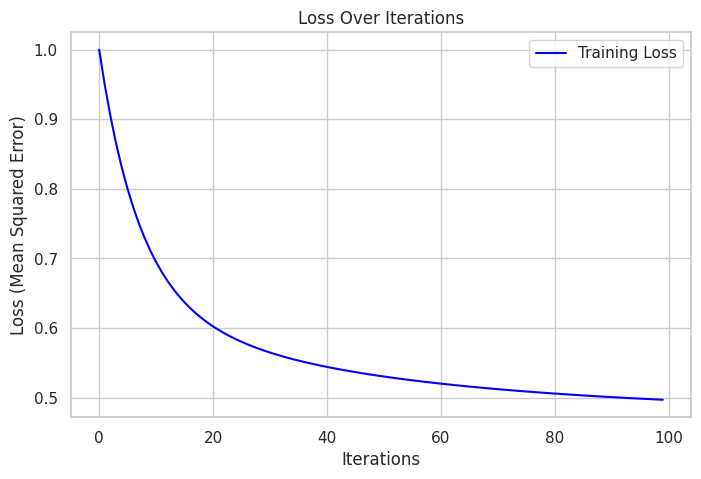

In [ ]:
# Plot loss over iterations
plt.figure(figsize=(8,5))
plt.plot(range(len(loss)), loss, label="Training Loss", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Loss (Mean Squared Error)")
plt.title("Loss Over Iterations")
plt.legend()
plt.grid(True)
plt.show()

**Explanation:** The graph shows the loss (Mean Squared Error) over iterations during the training of the Linear Regression model. The blue curve represents the training loss, which decreases steadily as the number of iterations increases. Initially, the loss drops rapidly, indicating fast learning, then gradually slows, showing convergence. This suggests that the model is learning effectively and minimizing the error over time. The final loss is low, indicating a well-fitted model.

In [ ]:
# Predict on test data
y_pred = model.forward_propagation(X_test)

# Convert predictions back to original scale
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Display predictions
print("Predicted Prices:", y_pred[:10])  # Show first 10 predictions

Predicted Prices: [2.88755000e+08 3.48252002e+08 5.69719121e+08 3.96246185e+08
 2.82908134e+08 5.38645664e+08 3.67021120e+08 4.06772315e+08
 3.89314312e+08 3.63776545e+08]


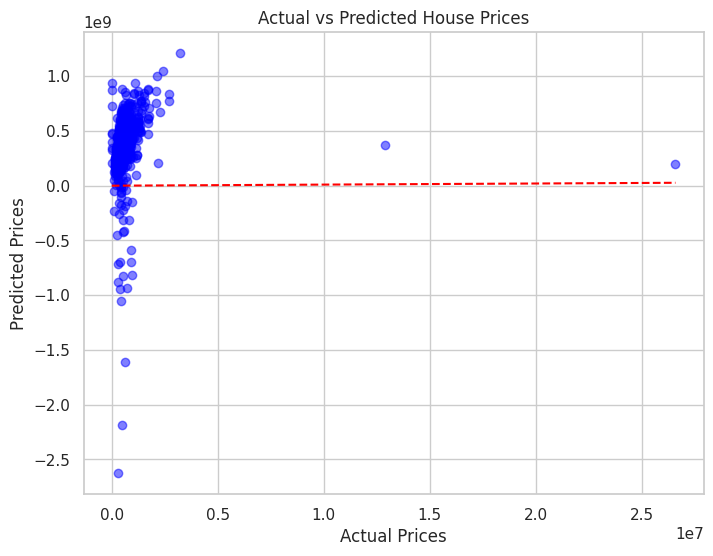

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.plot([min(y_test), max(y_test)],
         [min(y_test), max(y_test)],
         linestyle="--", color="red")  # Reference Line (Ideal Predictions)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()


In [ ]:
# Predictions
y_pred_train = model.forward_propagation(X_train)

# Convert predictions back to original scale
y_pred_train = y_scaler.inverse_transform(y_pred_train.reshape(-1, 1)).flatten()
y_actual_train = y_scaler.inverse_transform(y_train.reshape(-1, 1)).flatten()

# Compute MSE
mse = np.mean((y_actual_train - y_pred_train) ** 2)
r2_score = 1 - (np.sum((y_actual_train - y_pred_train) ** 2) / np.sum((y_actual_train - np.mean(y_actual_train)) ** 2))

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2_score:.4f}")


Mean Squared Error (MSE): 70561986520.03
R² Score: 0.5034
